# Data Exploratory

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import zipfile
path_to_zip_file='/content/drive/My Drive/Data/Vision/Histopathologic_Cancer/train.zip'
directory_to_extract_to='/content/train/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [4]:
import pandas as pd
path2csv="/content/drive/My Drive/Data/Vision/Histopathologic_Cancer/train_labels.csv"
labels_df=pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
print(labels_df['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


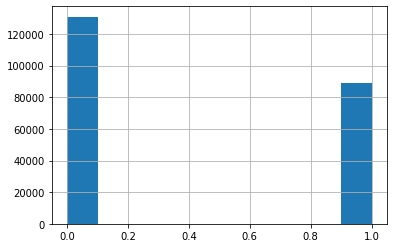

In [6]:
%matplotlib inline
labels_df['label'].hist();

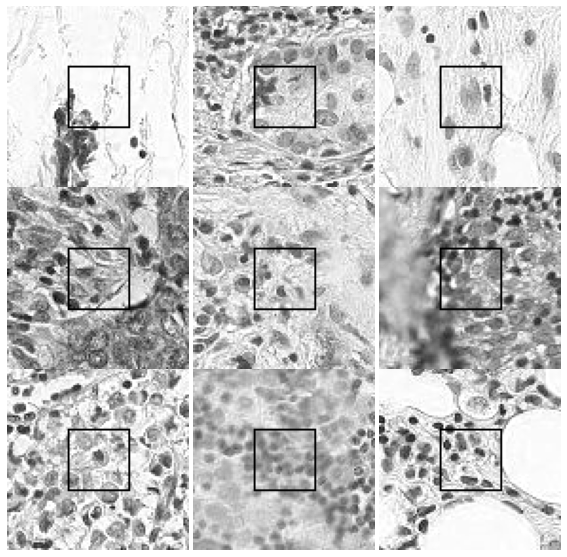

In [7]:
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

# data is stored here
path2train=directory_to_extract_to

# show images in gray-scale, if you want color change it to True
color=False

# get ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=3,3
for i,id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train , id_ +'.tif')
 
    # load image
    img = Image.open(full_filenames)

    # draw a 32*32 rectangle 
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)),outline="green")

    plt.subplot(nrows, ncols, i+1) 
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0],cmap="gray")
    plt.axis('off')

In [8]:
print("image shape:", np.array(img).shape)
print("pixel values range from %s to %s" %(np.min(img), np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


# Create a Custom Dataset

A traditional method for working with a dataset would be to load all images into NumPy
arrays. Since we are dealing with a relatively large dataset, this would be a waste of our
computer resources. If you are short on RAM, this would be impossible. Luckily, PyTorch
has a powerful tool to handle large datasets.

We can create a custom Dataset class by subclassing the PyTorch Dataset class. When
creating a custom Dataset class, make sure to define two essential functions: __len__ and
__getitem__. The __len__ function returns the dataset's length. This function is callable
with the Python len function. The __getitem__ function returns an image at the specified
index.

In step 1, we imported the required packages. The PIL package is imported to load images.
From torch.utils.data, we import Dataset as the base class of our custom dataset. The
pandas package is imported to load the CSV files. We also used torchvision for data
transformation.

Then, we defined the Dataset class. In the __init__ function, we received the path to the
data and the data_type. The data_type can be either train or test. The class, like any
PyTorch dataset, has the __len__ and __getitem__ functions. The __len__ function
returns the length of the dataset. The __getitem__ function also returns the transformed
image at the given index and its corresponding label.

In [31]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

# fix torch random seed
torch.manual_seed(0)

class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):      
    
        # path to images
        path2data=os.path.join(data_dir,data_type)
        print(path2data)

        # get list of images
        filenames = os.listdir(path2data) # all file in path
        print(filenames[:5])

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        print(self.full_filenames[:5])

        # labels are in a csv file named train_labels.csv
        #path2csvLabels=os.path.join(data_dir,"train_labels.csv")
        path2csvLabels=path2csv
        print(path2csvLabels)
        labels_df=pd.read_csv(path2csvLabels)
        print(labels_df)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        print(labels_df)

        # obtain labels from data frame
        # Dan nhan toan bo file name trong training voi label value tu labels_df
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        print(self.labels[:5])

        self.transform = transform
      
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In step 2, we defined the transformation function. For now, we only convert PIL images into
Pytorch tensors in the transformation function.

In [32]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

In [33]:
#data_dir = "../input/histopathologic-cancer-detection/" # must contain label and all images
data_dir='/content/'
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

/content/train
['434e2f5a3a7bfe53880839153f0fa668fdf43068.tif', '7ca55290e15ac9d28bc400d2a01e93dce2dff15d.tif', '9821ceb6dd70a1ef7e13bc59801f4d69f86b2694.tif', 'fa5ac1ec8f2aecd8ba30392e015076062da82c0d.tif', 'c3781ee152c9927da3ef73936c609c1305e55f80.tif']
['/content/train/434e2f5a3a7bfe53880839153f0fa668fdf43068.tif', '/content/train/7ca55290e15ac9d28bc400d2a01e93dce2dff15d.tif', '/content/train/9821ceb6dd70a1ef7e13bc59801f4d69f86b2694.tif', '/content/train/fa5ac1ec8f2aecd8ba30392e015076062da82c0d.tif', '/content/train/c3781ee152c9927da3ef73936c609c1305e55f80.tif']
/content/drive/My Drive/Data/Vision/Histopathologic_Cancer/train_labels.csv
                                              id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...             

KeyError: ignored

In [ ]:
histo_dataset.labels

[1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


In [ ]:
histo_dataset.full_filenames

['../input/histopathologic-cancer-detection/train/98e0b957f30e872eb6d2d7c3f4987ac14c480242.tif',
 '../input/histopathologic-cancer-detection/train/3e86d66775fc2d79084f3aed4857bd17c8ace7fd.tif',
 '../input/histopathologic-cancer-detection/train/c013abeae7a78f9520f264f831c66c8d68bbe044.tif',
 '../input/histopathologic-cancer-detection/train/c2d0f6854c055d05f39d8c63a58c4118712a5232.tif',
 '../input/histopathologic-cancer-detection/train/1e032f0ddfcad506fd190b4a0f1250fa107c78e6.tif',
 '../input/histopathologic-cancer-detection/train/a8639058782492558f3c92989ad40e62e9a8e2ba.tif',
 '../input/histopathologic-cancer-detection/train/4365c1cc4ea666186517f03c0c67e052d688dbe7.tif',
 '../input/histopathologic-cancer-detection/train/0e21757409d7fba8952cddce6de3b88711a5fcb0.tif',
 '../input/histopathologic-cancer-detection/train/f7ae8834fe9a3cbe2abc67274ba303851671f960.tif',
 '../input/histopathologic-cancer-detection/train/2297db701e3b2dbebd71f9dd34921d46532e5afc.tif',
 '../input/histopathologic-can

In step 4, we can see that the dataset returns images in the (Channels, Height, Width) format
and pixel values are normalized to the range [0.0, 1.0]. This is the result of transforms.
ToTensor() converts a PIL image into the range [0, 255] to torch.FloatTensor of
shape (C x H x W) in the range [0.0, 1.0]. It is common to use this formatting when working
with images in PyTorch.

In [ ]:
# load an image
img,label=histo_dataset[9]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


In [ ]:
# load an image
img,label=histo_dataset[1]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


In [ ]:
img

tensor([[[0.9608, 0.9804, 1.0000,  ..., 0.9961, 0.9451, 0.9569],
         [0.9098, 0.9333, 0.9647,  ..., 0.9569, 0.9608, 1.0000],
         [0.9882, 0.9804, 0.9804,  ..., 0.9490, 1.0000, 0.9569],
         ...,
         [1.0000, 0.9882, 0.9922,  ..., 0.9882, 0.9882, 0.9961],
         [0.9882, 0.9922, 0.9843,  ..., 0.9882, 0.9961, 0.9961],
         [0.9804, 0.9922, 0.9725,  ..., 0.9882, 0.9961, 0.9961]],

        [[0.9373, 0.9608, 0.9922,  ..., 0.9961, 0.9451, 0.9569],
         [0.8863, 0.9137, 0.9451,  ..., 0.9529, 0.9569, 1.0000],
         [0.9647, 0.9608, 0.9608,  ..., 0.9333, 0.9961, 0.9412],
         ...,
         [0.9922, 0.9804, 0.9843,  ..., 0.9804, 0.9804, 0.9804],
         [0.9804, 0.9843, 0.9765,  ..., 0.9804, 0.9804, 0.9804],
         [0.9725, 0.9843, 0.9647,  ..., 0.9804, 0.9804, 0.9804]],

        [[0.9529, 0.9765, 1.0000,  ..., 0.9882, 0.9373, 0.9490],
         [0.9020, 0.9294, 0.9608,  ..., 0.9451, 0.9490, 0.9922],
         [0.9804, 0.9765, 0.9765,  ..., 0.9294, 0.9922, 0.

# Split Dataset

In step 1, we used the random_split function from torch.utils.data to split the
dataset. This will return two datasets: train_ds and val_ds with lengths of 176020 and
44005, respectively

In [ ]:
from torch.utils.data import random_split

len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))


train dataset length: 176020
validation dataset length: 44005


In [ ]:
train_ds

In [ ]:
i=0
for x,y in train_ds:
    print(x.shape,y)
    i+=1
    if i == 5: 
        break

torch.Size([3, 96, 96]) 1
torch.Size([3, 96, 96]) 0
torch.Size([3, 96, 96]) 1
torch.Size([3, 96, 96]) 1
torch.Size([3, 96, 96]) 0


In [ ]:
for x,y in val_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 0


image indices: [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


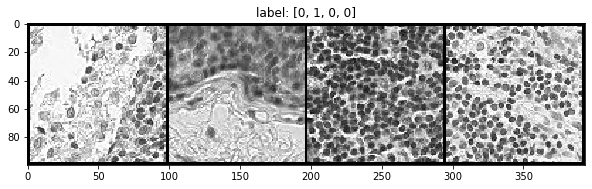

In [ ]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)


def show(img,y,color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    if color==False:
        npimg_tr=npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))

grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ds[i][0] for i in rnd_inds]
y_grid_train=[train_ds[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train,y_grid_train)

In [ ]:
train_ds[0]

(tensor([[[0.7686, 0.6941, 0.7176,  ..., 0.8314, 0.7843, 0.8196],
          [0.4863, 0.4588, 0.5098,  ..., 0.8706, 0.8863, 0.7098],
          [0.4235, 0.3882, 0.4000,  ..., 0.8353, 0.7922, 0.7490],
          ...,
          [0.8039, 0.8510, 0.8784,  ..., 0.4588, 0.5882, 0.4667],
          [0.7922, 0.8353, 0.8314,  ..., 0.6863, 0.6510, 0.6706],
          [0.8118, 0.7216, 0.8549,  ..., 0.7686, 0.6902, 0.7176]],
 
         [[0.4784, 0.4039, 0.4157,  ..., 0.5686, 0.4706, 0.4627],
          [0.2275, 0.2000, 0.2510,  ..., 0.5686, 0.5412, 0.3373],
          [0.2235, 0.1843, 0.1961,  ..., 0.5020, 0.4510, 0.3961],
          ...,
          [0.7608, 0.8157, 0.8431,  ..., 0.2824, 0.3922, 0.2627],
          [0.7569, 0.8000, 0.7882,  ..., 0.4706, 0.4353, 0.4588],
          [0.7843, 0.6941, 0.8118,  ..., 0.5176, 0.4510, 0.4824]],
 
         [[0.7725, 0.6980, 0.7216,  ..., 0.7412, 0.6784, 0.6941],
          [0.5686, 0.5451, 0.6039,  ..., 0.8745, 0.8784, 0.6902],
          [0.5961, 0.5686, 0.5882,  ...,

image indices: [30403 32103 41993 20757]
torch.Size([3, 100, 394])


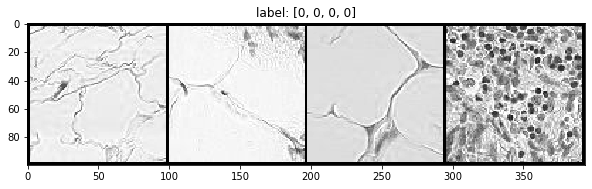

In [ ]:
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ds[i][0] for i in range(grid_size)]
y_grid_val=[val_ds[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)

show(x_grid_val,y_grid_val)

# Transform Data

Image transformation and image augmentation are necessary for training deep learning
models. By using image transformations, we can expand our dataset or resize and
normalize it to achieve better model performance. Typical transformations include
horizontal and vertical flipping, rotation, and resizing. The good news is that we can use
various image transformations for our binary classification model without making label
changes. For instance, if we rotate or flip a malignant image, it will remain malignant. In
this recipe, you will learn how to use the torchvision package to perform on-the-fly
image transformation during training.

In step 1, RandomHorizontalFlip and RandomVerticalFlip will flip the image
horizontally and vertically with a probability of 0.5, respectively.
The RandomRotation function rotates images in the range of [-45,45] degrees.
Also, RandomSizedCrop crops a square image randomly in the range of [72, 96] and then
resizes it to the original size of 96*96.

In [ ]:
#1. First, let's define the following transformations for the training dataset:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])             

In step 2, we used transforms.ToTensor to normalize the images in the range [0, 1] and
convert them into tensors. It is common to normalize images to zero-mean and unitvariance by subtracting the mean and diving into the standard deviation of the pixel values.
However, here, we opt not to do any further normalization.
The validation dataset was only normalized to the range [0, 1] without any data
augmentation.

In [ ]:
#2. For the validation dataset, we don't need any augmentation. So, we only convert
#the images into tensors in the transforms function:
val_transformer = transforms.Compose([transforms.ToTensor()])     

Finally, in step 3, we defined the transformations and overwrote the transform functions of
train_ds and val_ds.

In [ ]:
# overwrite the transform functions
train_ds.transform=train_transformer
val_ds.transform=val_transformer

In [ ]:
dir(train_ds)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'dataset',
 'indices',
 'transform']

In [ ]:
len(train_ds)

176020

# Create Dataloader

We are ready to create a PyTorch dataloader. If we do not use dataloaders, we have to write
code to loop over datasets and extract a data batch. This process can be made automatically
using a PyTorch Dataloader.

In step 1, when defining a PyTorch Dataloader, we need to define the batch size. The batch
size determines the number of images to be extracted from the dataset in each iteration. The
typical values of the batch size for classification tasks are in the range of [8-128]. Also, note
that we do not need to shuffle the validation data during evaluation.

When iterating over a dataloader, it will automatically extract batches of data from the
dataset. As seen in step 2, for the train dataloader, we extracted batches of images that were
32 in size. This was 64 for the validation dataloader since we set the batch size to 64.

In [ ]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)  

In [ ]:
len(train_dl) # 5501 batchs, each batch have 32 image --> total 176032 images

5501

In [ ]:
# extract a batch from trainin data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break


torch.Size([32, 3, 96, 96])
torch.Size([32])


In [ ]:
x

tensor([[[[0.7765, 0.9569, 0.9216,  ..., 0.8118, 0.8588, 0.7020],
          [0.8667, 0.9333, 0.9373,  ..., 0.5922, 0.6824, 0.8039],
          [0.9412, 0.9020, 0.9529,  ..., 0.8000, 0.8314, 0.8510],
          ...,
          [0.8784, 0.8549, 0.8000,  ..., 0.9176, 0.9608, 0.9725],
          [0.8902, 0.9176, 0.8941,  ..., 0.8863, 0.9020, 0.9216],
          [0.9490, 0.8863, 0.8118,  ..., 0.9569, 0.9373, 0.9373]],

         [[0.5882, 0.7922, 0.7922,  ..., 0.5216, 0.5765, 0.4275],
          [0.6902, 0.7765, 0.8196,  ..., 0.3059, 0.3961, 0.5216],
          [0.7961, 0.7725, 0.8549,  ..., 0.5137, 0.5451, 0.5647],
          ...,
          [0.6784, 0.6667, 0.6196,  ..., 0.8980, 0.9333, 0.9333],
          [0.7098, 0.7412, 0.7373,  ..., 0.8549, 0.8627, 0.8863],
          [0.7725, 0.7294, 0.6627,  ..., 0.9255, 0.8980, 0.8941]],

         [[0.7529, 0.9412, 0.9137,  ..., 0.8235, 0.8745, 0.7137],
          [0.8431, 0.9137, 0.9294,  ..., 0.6157, 0.7059, 0.8196],
          [0.9255, 0.8863, 0.9412,  ..., 0

In [ ]:
y

tensor([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
# extract a batch from validation data
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 96, 96])
torch.Size([64])


# Building Classification Model

## dumb baselines

In step 1, we created dumb baselines. We should always establish a baseline before moving
forward with complex models. This will help us find out how well we are performing. We
can create dumb baselines by creating random predictions, all-zero predictions, or all-one
predictions. Let's create simple baselines using these predictions. It is interesting to see that
we can get an accuracy of 0.60 with dumb predictions.

In [ ]:
# get labels for validation dataset
y_val=[y for _,y in val_ds]    

def accuracy(labels, out):
    return np.sum(out==labels)/float(len(labels))

# accuracy all zero predictions
acc_all_zeros=accuracy(y_val,np.zeros_like(y_val))

# accuracy all ones predictions
acc_all_ones=accuracy(y_val,np.ones_like(y_val))

# accuracy random predictions
acc_random=accuracy(y_val,np.random.randint(2,size=len(y_val)))

print("accuracy random prediction: %.2f" %acc_random)
print("accuracy all zero prediction: %.2f" %acc_all_zeros)
print("accuracy all one prediction: %.2f" %acc_all_ones)

accuracy random prediction: 0.50
accuracy all zero prediction: 0.59
accuracy all one prediction: 0.41


## find Output size

 Let's implement a helper function to calculate the output size of a CNN layer
 
In step 2, we developed findConv2DOutShape to automatically compute the output size of
- a CNN and pooling layer. The inputs to this function are:
- H_in: an integer representing the height of input data
- W_in: an integer representing the width of input data
- conv: an object of the CNN layer
- pool: an integer representing the pooling size and default to 2

In [ ]:
import torch.nn as nn

def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)


# example
conv1 = nn.Conv2d(3, 8, kernel_size=3) # in channel: 3 (R,P,G), out channel: 8 (filter)
h,w=findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


## Define Model

In this section, we will build a model for our binary classification task. Our model is
comprised of four convolutional neural networks (CNNs) and two fully connected layers,
as shown in the following diagram:

In step 3, we implemented the CNN model using the nn.Module class. In the __init__
function, we define the layers of the model. We provide the model parameters as a Python
dictionary to this function. We recommend using variables for the model parameters and a
dictionary to define them outside the class. This way, in the case of parameter changes, we
do not have to make changes inside the Net class. This will also make future
hyperparameter searches easier.

For most layers, it is important to specify the number of inputs and outputs of the layer. For
instance, the first CNN layer has C_in=3 channels as input and init_f=8 filters as output,
as defined in the following code:

self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)

Similarly, the second CNN layer receives init_f=8 channels as input and 2*init_f=16
channels as output. Thus, by providing the number of output channels of the previous layer
as the number of input channels to the next layer, we can define each layer. However, this
becomes tricky when it comes to nn.Linear layers. The linear layer accepts a 2D tensor.
That is why we need the view method in the forward function to reshape the 4D tensor
into a 2D tensor:

flatten/reshape

x = x.view(-1, self.num_flatten)

How do we get the value of self.num_flatten? Well, PyTorch does not automatically
calculate this value. It is our duty to find this value and provide it to the linear layer. One
approach would be to print (x.size()) to get the output shape of each layer.

The other option is using the findConv2DOutShape function. The output size of the fourth
CNN layer (together with the pooling layer) is h,w and there are 8*init_f output
channels. Therefore, after flattening, we get self.num_flatten=h*w*8*init_f.

We also added a dropout layer before the output layer to reduce the overfitting problem in
deep learning models. Notice that we set the training = self.training argument in
the F.dropout function. The self.training parameter is automatically set to True
during training and False at evaluation. This will bypass the dropout layer at the
deployment time.

The dropout layer is only applied during training. At deployment, the
dropout layer should be deactivated. To do so, make sure to set training
argument of the dropout layer to False at deployment.

The last layer is F.log_softmax(x, dim=1) (with two outputs), which is equivalent to
. We will explain why we choose this output in the next section when
defining the loss function. Keep in mind that if we want to get the output probability value,
we need to use the exponential operation.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
        C_in,H_in,W_in=params["input_shape"] #3x96x96
        init_f=params["initial_filters"]  #8
        num_fc1=params["num_fc1"]  #100
        num_classes=params["num_classes"]  #2
        self.dropout_rate=params["dropout_rate"] #0.25 
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3) #3,8,3
        h,w=findConv2dOutShape(H_in,W_in,self.conv1) # 96x96,self.conv1
        print(h,w) # 47x47
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        print(h,w) # 22x22
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        print(h,w) # 10x10

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        print(h,w) # 4x4
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f # 4x4x8x8
        print(self.num_flatten)#1024
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        #The linear layer accepts a 2D tensor.That is why we need the view method in the 
        #forward function to reshape the 4D tensor into a 2D tensor:
        x = x.view(-1, self.num_flatten)
        
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In step 4, we constructed an object of the Net class. The input shape is the shape of the
image tensors (3,96,96). We choose initial_filters=8 filters for the first CNN layer. The
number of filters is automatically doubled in the next layers. Also, there are num_fc1=100
units in the fully connected layer.

In [ ]:
# dict to define model parameters
params_model={
        "input_shape": (3,96,96),
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2,
            }

# create model
cnn_model = Net(params_model)


47 47
22 22
10 10
4 4
1024


In step 5, if you have a CUDA device, always move the model to the CUDA device to take
advantage of the computation acceleration.

In [ ]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device) 

In [ ]:
print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [ ]:
print(next(cnn_model.parameters()).device)

cpu


In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96))
#Conv2d-1 : -1, 8 filter, 94 height , 94 width
#Conv2d-2 : -1, 16 filter, 45 height, 45 width

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


Then, we showed the model summary. The summary shows the output shape and the
number of parameters per layer. However, this does not include the functional layers. It is
interesting to see that the fully connected layer has the highest number of parameters
(102500), which is not efficient. Therefore, state-of-the-art deep learning models eliminate
fully connected layers in their design.

# Loss function

Output Activation | Number of Outputs | Loss Function

None |1 |nn.BCEWithLogitsLoss

Sigmoid| 1 |nn.BCELoss

None |2 |nn.CrossEntropyLoss

log_softmax |2 |nn.NLLLoss

We recommend using the log_softmax function as it is easier to expand to multi-class
classification. PyTorch combines the log and softmax operations into one function due to
numerical stability and speed.

We use log_softmax as the output and nn.NLLLoss as the negative log-likelihood
loss. An important argument in defining the loss function to pay attention to is the
reduction, which specifies the reduction to apply to the output. There are three options to
choose from: none, sum, and mean. We choose reduction=sum so that the output loss will
be summed. Since we will process the data in batches, this will return the sum of loss
values per batch of data.

In [ ]:
loss_func = nn.NLLLoss(reduction="sum")

 Next, we will use the loss in an example:
 
In step 2, we calculate the loss using an example with n=8 samples and c=2 classes.

In step 3, we compute the gradients for the example in step 2. Later, we will use the
backward method to compute the gradients of the loss with respect to the model
parameters.

In [ ]:
# fixed random seed
torch.manual_seed(0)

n,c=8,2
y = torch.randn(n, c, requires_grad=True)
print(y)
ls_F = nn.LogSoftmax(dim=1)
y_out=ls_F(y)
print(y_out)
print(y_out.shape)

target = torch.randint(c,size=(n,))
print(target)
print(target.shape)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]], requires_grad=True)
tensor([[-0.6800, -0.7065],
        [-0.6057, -0.7890],
        [-0.6179, -0.7746],
        [-0.1531, -1.9523],
        [-0.1863, -1.7719],
        [-0.6724, -0.7143],
        [-1.4007, -0.2829],
        [-0.2276, -1.5917]], grad_fn=<LogSoftmaxBackward>)
torch.Size([8, 2])
tensor([0, 0, 0, 1, 0, 1, 1, 0])
torch.Size([8])


In [ ]:
loss = loss_func(y_out, target)
print(loss.item())

5.266995429992676


In [ ]:
loss.backward()
print (y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


# Defining Optimizer

The torch.optim package provides the implementation of common optimizers. The
optimizer will hold the current state and will update the parameters based on the
computed gradients. For binary classification tasks, SGD and Adam optimizers are used the
most.

Another helpful tool in the torch.optim package is learning schedules. Learning
schedules are useful tools for automatically adjusting the learning rate during training to
improve model performance.

In step 1, we defined the Adam optimizer. The important parameters of the optimizer class
are the model's parameters and the learning rate. cnn_model.parameters() returns an
iterator over module parameters that are passed to the optimizer. The learning rate will
determine the amount to update by. In PyTorch, we can set a different learning rate per
layer, but in this chapter, we'll choose to set one learning rate for all the layers. In step 2, we
developed a helper function that returns the current value of the learning rate.

In [ ]:
#1. First, let's define an object of the Adam optimizer with a learning rate of 3e-4:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

In [ ]:
#2. We can read the current value of the learning rate using the following function:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))


current lr=0.0003


In step 3, we used the ReduceLROnPlateau method from
the torch.optim.lr_scheduler package. This scheduler reads a metric quantity and if
no improvement is seen for a patience number of epochs, the learning rate is reduced by a
factor of 0.5. The mode argument defines whether the metric quantity is increasing or
decreasing during training. For instance, if we monitor the loss value, we set mode='min'.
If we monitor the accuracy, we should set mode='max'.

In step 4, we showed you how the learning rate schedule works by passing it a constant
value during a loop. As we saw, after every 20 iterations, the scheduler reduces the learning
rate by half.

In [ ]:
# 3. Next, we will define a learning scheduler using the ReduceLROnPlateau method:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [ ]:
# 4. Then, we will learn how the learning rate schedule works using the following example:
for i in range(100):
    lr_scheduler.step(1)


Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


# Training and Evaluation

So far, we've created the datasets, built the model, and defined the loss function and
optimizer. In this recipe, we'll implement the training and validation scripts. The training
and validation scripts can be long and repetitive. For better code readability and to avoid
code repetition, we'll build a few helper functions first.

1. First, let's develop a helper function to count the number of correct predictions
per data batch:

In step 1, we counted the number of correct predictions per batch to be used for calculating
the model accuracy.

In [ ]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [ ]:
n,c=8,2
output = torch.randn(n, c, requires_grad=True)
print (output)
print(output.shape)

#target = torch.randint(c,size=(n,))
target = torch.ones(n,dtype=torch.long)
print(target.shape)

metrics_batch(output,target)

2. Then, we will develop a helper function to compute the loss value per batch of
data:

In step 2, the loss_batch function receives the objects of the loss function and optimizer,
the model output, and the ground truth label. We only perform the backpropagation step
during training.

In [ ]:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b


3. Next, we develop a helper function to compute the loss value and the
performance metric for the entire dataset, also called an epoch

In step 3, the loss_epoch function receives the objects of the model, the loss function, a
Dataloader, and the optimizer. We used the Dataloader to fetch batches of data from the
dataset. Then, we moved the batch to the CUDA device and got the model's output. We
also declared two variables to keep the loss and number of correct predictions after a batch
is executed. You can see how the choice of reduction="sum" in the definition of the loss
function is deployed to accumulate the loss over the entire dataset. The sanity_check flag
breaks the loop to quickly execute the function in the case of debugging

In [ ]:
# define device as a global variable
device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

4. Let's develop the train_val function in the following code blocks.The function is too long, so we will present it in a few steps. Keep in mind that all
the following code blocks belong to one function.

In step 4, we passed the parameters as a Python dictionary. This will improve the code's
readability. We defined two dictionaries to record the loss and metric values during
training for visualization purposes.

In [ ]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    '''
    An important step is to track the model's performance during training to avoid overfitting.
    To this end, we evaluate the model on the validation dataset after each training epoch.
    Then, we compared the validation loss with the best validation loss, val_loss <
    best_loss. If the validation loss has improved, we store and make copies of the weights as
    the best model weights.
    '''
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        '''
        The learning rate scheduler monitors the validation loss and reduces the learning rate by a
        factor of two
        Also, every time the learning rate is reduced, we would like to continue training from the
        best weights:
        '''
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

5. Let's set the sanity_check flag to True and run the code.

Developing and training deep learning models is time-consuming. The last thing you want
is an error popping up somewhere in the middle of training. We recommend performing a
sanity check before starting the actual training. We created a flag called sanity_check for
this purpose. If set to True, the training loop breaks after one batch in an epoch. Therefore,
we get to see the whole loop in a short amount of time.

In step 5, the sanity check should quickly train and evaluate the model for 100 epochs.
Everything looks normal. Even the learning rate schedule was activated and reduced the
learning rate from 3e-4 to 7.5e-5. The training loss converges to near zero, which makes it
clear that we can overfit to one batch. Don't worry about accuracy. This is a sanity check,
after all.

In [ ]:
# Define the objects for the optimization, loss, and learning rate schedule:
import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)
# Define the training parameters and call the train_val helper function:
params_train={
 "num_epochs": 100,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": True,
 "lr_scheduler": lr_scheduler,
 #"path2weights": "./models/weights.pt",
  "path2weights": "weights.pt"  
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

This will print out the following output:

Epoch 0/99, current lr=0.0003

Copied best model weights!

train loss: 0.000129, dev loss: 0.001024, accuracy: 0.05

....

Epoch 1/99, current lr=0.0003

Copied best model weights!

train loss: 0.000125, dev loss: 0.001021, accuracy: 0.05

6. Let's plot the training validation's progress using the returned values, that
is, loss_hist and metric_hist:

In step 6, we saw that, at some point, the learning rate schedule will reduce the learning rate
after the validation loss does not improve for 20 epochs. When this happens, the model is
reloaded with the last best weights. That is why we see sudden jumps in the loss and
accuracy curves at these points.

We stored the best model weights (state_dict) during training by tracking the model's
performance on the validation dataset. The weights are located in
the ./models/weights.pt path. This is useful in case the program is stopped for any
reason – at least you have a copy of the best weights.

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

7. By doing this, we've made sure that all the elements are implemented correctly.
Let's set the flag to sanity_check: False and run the code. The training will
start and we will see its progress, as shown in the following code block:

In [ ]:
%%time
import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

params_train={
 "num_epochs": 2,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "./weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

There's more...

Once you get a baseline performance using your first model, you can start tuning
hyperparameters. Hyperparameter tuning is a technique that's used to improve model
performance. An effective way of doing this is by using a random search. We defined the
hyperparameters as variables so that you can easily play with them. Try different values for
the hyperparameters and see how the model's performance is affected. As an example, try
increasing the number of CNN filters by setting initial_filters = 16 and retraining
the model.